In [1]:
import os
import time
import dill
from typing import List
from functools import reduce
from calendar import monthrange

In [2]:
import json
import csv
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import urllib.request as urllib2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from random import sample, randint, shuffle
from sklearn.decomposition import PCA

In [4]:
import nltk
import text_summarizer
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize
from gensim.models import Word2Vec, LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [5]:
from time import process_time

In [6]:
t = process_time()
dill.load_session('thesis_env3.db')
process_time() - t

-2203.301164

In [7]:
len(politics), len(movies), len(books)

(7370, 7370, 7370)

In [8]:
len(adjectives), len(objects), len(cities)

(393, 192, 2010)

In [9]:
len(all_)

1685787

In [ ]:
# mpol, mmov, mbooks
# summaries_{pol, mov, bks}
# m{pol, mov, bks}_{s, b, c}
# bow_{pol, mov, bks}
# ctrs_{pol, mov, bks}

In [10]:
len(pairs), len(proflist), len(gender_specific)

(52, 205, 218)

In [12]:
len(vocab), len(vocab2)

(21808, 7519)

In [54]:
vocab = set(mpol.wv.vocab)
for m in [mpol, mmov, mbooks]:
    vocab &= set(m.wv.vocab)
len(vocab)

21808

In [55]:
vocab_all = set(vocab)
for m in [mpol_s, mbks_s, mmov_s] + \
[mpol_b, mbks_b, mmov_b] + \
[mpol_c, mbks_c, mmov_c]:
    vocab_all &= set(m.wv.vocab)
len(vocab_all)

7519

In [56]:
vocab2 = vocab_all

# Projection Bias

Text(0.5, 1.0, 'Explained Variance vs Component Number (Random)')

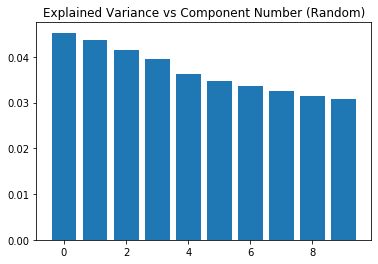

In [165]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(70,100))
plt.bar(range(10), pca_r.explained_variance_ratio_)
plt.title("Explained Variance vs Component Number (Random)")

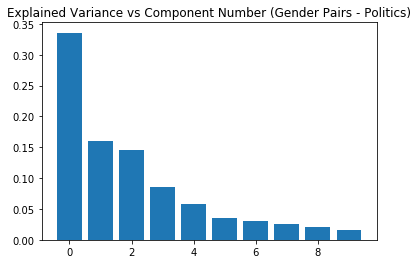

In [140]:
gpol = getg(mpol, "Gender Pairs - Politics", True)

In [57]:
def getg(m):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    print(p.explained_variance_ratio_[0])
#         plt.bar(range(10), p.explained_variance_ratio_)
#         plt.title("Explained Variance vs Component Number (" + t + ")")
    return p.components_[0]

In [135]:
def gproj2(g1, g2, m, w1):
    wvec = m.wv.get_vector(w1)
    # g = project wvec onto g1, g2 subspace
    A = np.hstack((g1.reshape(100,1),g2.reshape(100,1)))
    P = A @ np.linalg.inv(A.T @ A) @ A.T
    g = P @ wvec
    p = np.dot(g, wvec)/(np.linalg.norm(g)*np.linalg.norm(wvec))
    return p

In [136]:
gpol_s1, gpol_s2 = getg(mpol_s)
res = sorted([(x, gproj2(gpol_s1, gpol_s2, mpol_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.3386617
though          0.00 		 chairman        0.87
proper          0.00 		 democrat        0.85
translate       0.00 		 speaker         0.81
combined        0.01 		 chief           0.79
modernity       0.01 		 james           0.79
fears           0.01 		 lawyer          0.78
moral           0.01 		 jr              0.78
excess          0.01 		 member          0.78
meaningful      0.01 		 leader          0.78
collection      0.01 		 secretary       0.77
sport           0.01 		 representative  0.77
dragging        0.01 		 john            0.76
practices       0.01 		 david           0.76
shifting        0.01 		 congressman     0.75
expenses        0.01 		 deputy          0.75


In [58]:
def gdictadd(models):
    for i in range(3):
        gdict[list(gdict)[i]].append(getg(models[i]))

In [95]:
gdict = {"politics": [], "books": [], "movies": []}
labels = ["original", "summary (TextRank)", "summary (Centroid-BOW)", "summary (control)"]
gdictadd([mpol, mmov, mbooks])
gdictadd([mpol_s, mbks_s, mmov_s])
gdictadd([mpol_b, mbks_b, mmov_b])
gdictadd([mpol_c, mbks_c, mmov_c])

0.34343678
0.52675015
0.5915069
0.31522945
0.78374213
0.62817353
0.31965494
0.8359838
0.7387123
0.32400513
0.768514
0.6437023


In [60]:
def mdictadd(models):
    for i in range(3):
        mdict[list(mdict)[i]].append(models[i])

In [96]:
mdict = {"politics": [], "books": [], "movies": []}
mdictadd([mpol, mmov, mbooks])
mdictadd([mpol_s, mbks_s, mmov_s])
mdictadd([mpol_b, mbks_b, mmov_b])
mdictadd([mpol_c, mbks_c, mmov_c])

In [62]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/(np.linalg.norm(g)*np.linalg.norm(wvec))
    return p

In [63]:
def bias(g, m, vocab, wordlist):
    b = 0
    l = list(filter(lambda x: x in vocab, wordlist))
    for x in l:
        b += abs(gproj(g, m, x))
    return b/len(l)

In [97]:
print(labels[0])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, cities), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, objects), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

original
  politics 0.094 0.064 0.071 0.058 0.112
     books 0.085 0.090 0.088 0.078 0.172
    movies 0.092 0.068 0.076 0.064 0.151


In [65]:
print(labels[1])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, proflist), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, cities), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, objects), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, gender_specific))

summary (TextRank)
  politics 0.361 0.112 0.289 0.140 0.269
     books 0.046 0.048 0.046 0.052 0.146
    movies 0.077 0.083 0.066 0.085 0.173


In [87]:
print(labels[2])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, proflist), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, cities), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, objects), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, gender_specific))

summary (Centroid-BOW)
  politics 0.483 0.154 0.431 0.224 0.401
     books 0.043 0.050 0.046 0.048 0.147
    movies 0.065 0.076 0.065 0.086 0.173


In [67]:
print(labels[3])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, proflist), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, cities), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, objects), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, gender_specific))

summary (control)
  politics 0.170 0.089 0.138 0.091 0.120
     books 0.043 0.043 0.038 0.048 0.121
    movies 0.059 0.065 0.050 0.068 0.154


In [13]:
gpol = getg(mpol)
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gbooks = getg(mbooks)
res = sorted([(x, gproj(gbooks, mbooks, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gmov = getg(mmov)
res = sorted([(x, gproj(gmov, mmov, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.34343678
her        -0.50 		 mr         0.43
women      -0.47 		 ouster     0.39
ms         -0.46 		 abbas      0.39
she        -0.46 		 mikhail    0.38
feeding    -0.37 		 mahmoud    0.37
disabled   -0.35 		 arafat     0.37
herself    -0.35 		 vladimir   0.37
mental     -0.34 		 himself    0.36
female     -0.34 		 kremlin    0.36
classroom  -0.32 		 hamid      0.35
0.5915069
mr         -0.45 		 her        0.60
baseball   -0.40 		 ms         0.58
himself    -0.40 		 herself    0.57
james      -0.37 		 she        0.51
kissinger  -0.37 		 husband    0.47
saul       -0.37 		 lily       0.44
military   -0.36 		 girl       0.43
eisenhower -0.36 		 heroine    0.42
john       -0.36 		 mary       0.40
ford       -0.36 		 women      0.40
0.52675015
steven     -0.52 		 ms         0.63
george     -0.48 		 her        0.52
mr         -0.47 		 marie      0.52
spielberg  -0.47 		 nicole     0.51
lucas      -0.42 		 herself    0.51
leone      -0.40 		 antoinette 0.50
himself    -0.40 		 actress    0

In [15]:
gpol_s = getg(mpol_s)
res = sorted([(x, gproj(gpol_s, mpol_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gbks_s = getg(mbks_s)
res = sorted([(x, gproj(gbks_s, mbks_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gmov_s = getg(mmov_s)
res = sorted([(x, gproj(gmov_s, mmov_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.31522945
these      -0.52 		 chairman   0.80
large      -0.44 		 secretary  0.78
low        -0.43 		 chief      0.77
without    -0.42 		 deputy     0.75
their      -0.40 		 speaker    0.74
different  -0.40 		 leader     0.73
small      -0.39 		 paul       0.67
making     -0.36 		 president  0.67
pay        -0.36 		 king       0.66
such       -0.36 		 director   0.66
0.78374213
mr         -0.38 		 her        0.63
he         -0.32 		 she        0.47
his        -0.30 		 herself    0.46
administration -0.28 		 husband    0.42
iraq       -0.27 		 baby       0.37
president  -0.26 		 girl       0.35
military   -0.26 		 children   0.31
bush       -0.26 		 mother     0.30
nations    -0.26 		 sister     0.30
history    -0.24 		 love       0.29
0.62817353
her        -0.57 		 disney     0.41
herself    -0.47 		 pictures   0.38
she        -0.44 		 production 0.35
husband    -0.41 		 studio     0.34
mother     -0.39 		 mr         0.34
ms         -0.38 		 producers  0.34
girl       -0.38 		 kong   

In [16]:
gpol_b = getg(mpol_b)
res = sorted([(x, gproj(gpol_b, mpol_b, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gbks_b = getg(mbks_b)
res = sorted([(x, gproj(gbks_b, mbks_b, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gmov_b = getg(mmov_b)
res = sorted([(x, gproj(gmov_b, mmov_b, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.31965494
these      -0.48 		 chairman   0.92
without    -0.41 		 democrat   0.87
their      -0.41 		 james      0.84
prices     -0.38 		 lawyer     0.83
nuclear    -0.37 		 representative 0.83
real       -0.36 		 jr         0.82
weapons    -0.35 		 speaker    0.82
large      -0.35 		 peter      0.81
oil        -0.35 		 secretary  0.81
further    -0.33 		 john       0.81
0.8359838
her        -0.63 		 mr         0.44
she        -0.50 		 his        0.41
husband    -0.44 		 he         0.37
herself    -0.41 		 bush       0.33
girl       -0.30 		 administration 0.31
woman      -0.29 		 himself    0.29
ms         -0.29 		 president  0.24
baby       -0.28 		 nations    0.23
children   -0.28 		 states     0.23
mother     -0.27 		 clinton    0.21
0.7387123
her        -0.60 		 mr         0.43
she        -0.51 		 disney     0.34
herself    -0.48 		 his        0.32
girl       -0.44 		 studio     0.28
husband    -0.41 		 rights     0.28
woman      -0.41 		 company    0.28
mother     -0.35 		 major

In [17]:
gpol_c = getg(mpol_c)
res = sorted([(x, gproj(gpol_c, mpol_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gbks_c = getg(mbks_c)
res = sorted([(x, gproj(gbks_c, mbks_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")
gmov_c = getg(mmov_c)
res = sorted([(x, gproj(gmov_c, mmov_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.32400513
mail       -0.37 		 head       0.52
or         -0.35 		 chairman   0.51
high       -0.35 		 union      0.51
got        -0.33 		 president  0.50
few        -0.32 		 leadership 0.48
com        -0.32 		 secretary  0.48
young      -0.31 		 chief      0.47
children   -0.31 		 powers     0.47
isn        -0.29 		 coalition  0.47
these      -0.28 		 leader     0.47
0.768514
her        -0.61 		 mr         0.38
herself    -0.46 		 his        0.31
she        -0.46 		 war        0.29
husband    -0.41 		 he         0.28
children   -0.30 		 bush       0.27
love       -0.28 		 civil      0.24
ms         -0.27 		 administration 0.23
mother     -0.27 		 ii         0.23
girl       -0.27 		 iraq       0.22
woman      -0.27 		 policy     0.20
0.6437023
disney     -0.38 		 her        0.55
mr         -0.37 		 she        0.47
major      -0.34 		 herself    0.41
studio     -0.34 		 husband    0.41
company    -0.33 		 girl       0.40
entertainment -0.33 		 woman      0.35
distribution -0.33 		 mothe

In [ ]:
gpol = getg(mpol)
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

# WEAT

## Regression for bias testing

In [140]:
def regress(g1, m1, g2, m2, wordlist):
    x = np.array([gproj(g1, m1, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    y = np.array([gproj(g2, m2, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, p_value

In [141]:
regress(gpol, mpol, gpols, mpols, proflist)

(0.533629121432331, 1.5349588515623742e-57)

In [142]:
regress(gcomp, mcomp, gcomps, mcomps, proflist)

(-0.47288942755651714, 6.5938456670774195e-21)

In [143]:
regress(gtrav, mtrav, gtravs, mtravs, proflist)

(0.1988740624251196, 4.7826899611645153e-17)